In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import GPy
import my_lib
import acquisitions as ac
from sklearn import preprocessing
import os
from contextlib import redirect_stdout
%matplotlib inline
SEED = 46

In [2]:
def f(x, a=1., b=5., c=2.):
    return a * np.sin((x+(c/5))*b)
np.random.seed(SEED)
_X = np.random.rand(4)
X = _X.copy()
Y = f(X)
X_array = np.linspace(0, 1, 100)
V = np.random.normal(0,0.01,X.size)

In [3]:
m = my_lib.models.myGPHeteroscedasticRegression(X[:,None],Y[:,None])
m['.*het_Gauss.variance'] = abs(V[:,None]) #Set the noise parameters to the error in Y
m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
m.het_Gauss.common_variance = abs(1)
m.het_Gauss.common_variance.fix()
with redirect_stdout(open(os.devnull, 'w')):
    m.optimize_restarts(num_restarts=100, messages=False, max_iters=10)

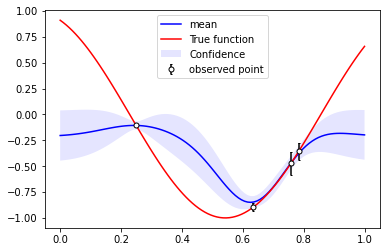

In [4]:
mu, std = np.array(m.predict(X_array[:, None]))
plt.plot(X_array, mu, c='b', label='mean')
plt.fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='b',alpha=0.1, label='Confidence')
plt.errorbar(X,Y,yerr=(np.array(m.het_Gauss.variance).flatten()*20),
             capsize=1, fmt='.', markersize=10, ecolor='black', 
             markeredgecolor = "black", color='w', label ='observed point')

plt.plot(X_array, f(X_array), c='r', label='True function')
plt.legend()

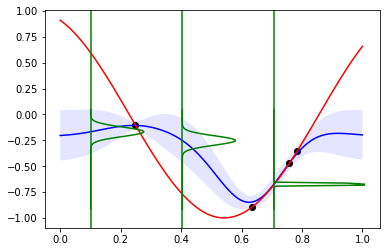

In [5]:
plt.plot(X_array, mu, c='b', label='mean')
plt.fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='b',alpha=0.1, label='Confidence')
plt.scatter(X, Y, c ='black', label ='observed point')
plt.plot(X_array, f(X_array), c='r', label='True function')
sample = np.linspace(10, 70, 3).astype(np.int)
tmp = np.linspace(np.min(mu-(std**0.5)), np.max(mu+(std**0.5)), 100)
for s in sample:
    dist = np.clip(sc.stats.norm.pdf(tmp, mu[s],std[s])*0.02, None, 0.3)
    plt.plot(dist+X_array[s], tmp, c = 'g')
    plt.axvline(x=X_array[s], c = 'g')

In [6]:
PI  = ac.AcquisitionEI()
EI  = ac.AcquisitionPI()
UCB = ac.AcquisitionGPUCB()

In [7]:
mms = preprocessing.MinMaxScaler()
pi  = mms.fit_transform(PI.acq(mu, std))
pi_idx = np.argmax(pi)
ei  = mms.fit_transform(EI.acq(mu, std))
ei_idx = np.argmax(ei)
ucb = mms.fit_transform(UCB.acq(mu, std))
ucb_idx = np.argmax(ucb)

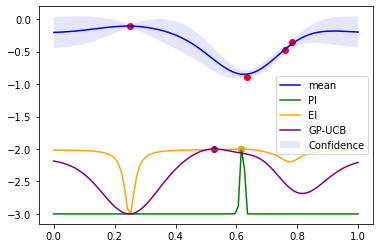

In [8]:
plt.plot(X_array, mu, c='b', label='mean')
plt.fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='b',alpha=0.1, label='Confidence')
plt.scatter(X, Y, c ='r')

plt.plot(X_array, pi-3, c='g', label='PI')
plt.plot(X_array, ei-3, c='orange', label='EI')
plt.plot(X_array, ucb-3,c='purple', label='GP-UCB')

plt.scatter(X_array[pi_idx], pi[pi_idx]-3, c='g')
plt.scatter(X_array[ei_idx], ei[ei_idx]-3, c='orange')
plt.scatter(X_array[ucb_idx], ucb[ucb_idx]-3, c='purple')

plt.legend()

4/4.......

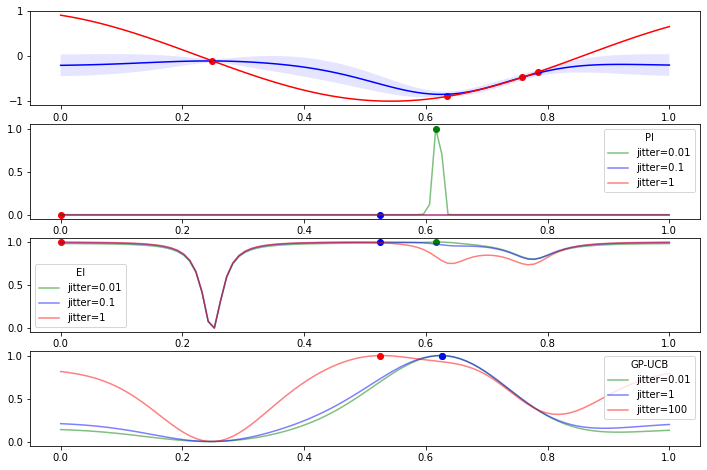

In [9]:
nrows=4
ncols=1
#pi
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(12,8))
mu, std = np.array(m.predict(X_array[:, None]))
ax[0].plot(X_array, mu, c='b', label='mean')
ax[0].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='b',alpha=0.1, label='Confidence')
ax[0].scatter(X, Y, c ='r')
ax[0].plot(X_array, f(X_array), c='r', label='True function')
for i in range(1, nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    acqs = [PI, EI, UCB]
    acqs_st = ['PI', 'EI', 'GP-UCB']
    params = [[0.01, 0.1, 1], [0.01, 0.1, 1], [0.01, 1, 100]]
    colors = ['g', 'b', 'r']
    for j in range(3):
        if i == 3:
            acqs[i-1].beta = params[i-1][j]
        else:
            acqs[i-1].jitter = params[i-1][j]
            #print(acqs[i-1].jitter)
        acq  = mms.fit_transform(acqs[i-1].acq(mu, std))
        idx = np.argmax(acq)
        
        ax[_r].plot(X_array, acq, c=colors[j], alpha=0.5, label=f'jitter={params[i-1][j]}')
        ax[_r].scatter(X_array[idx], acq[idx], c=colors[j])
    ax[_r].legend(title=acqs_st[i-1])

In [10]:
nrows=4
ncols=3

12/12.......

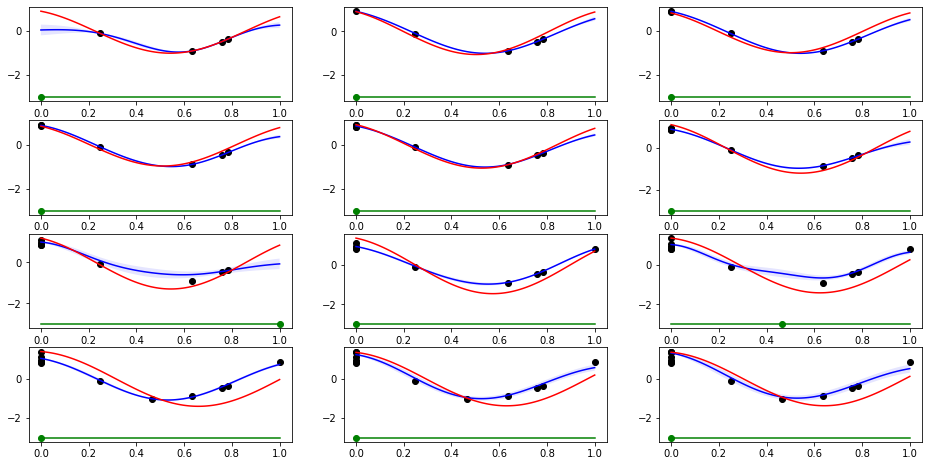

In [11]:
#pi
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16,8))
X = _X.copy()
Y = f(X)
V = np.ones_like(X)*1e-5
np.random.seed(SEED)
param = np.array([1., 5, 2.])
delta = np.random.normal(0,0.1,3*nrows*ncols).reshape((-1, 3))
for i in range(nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    m = my_lib.models.myGPHeteroscedasticRegression(X[:,None],Y[:,None])
    m['.*het_Gauss.variance'] = abs(V[:,None]) #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    with redirect_stdout(open(os.devnull, 'w')):
        m.optimize_restarts(num_restarts=100, messages=False, max_iters=10)
    mu, std = np.array(m.predict(X_array[:, None]))
    ax[_r, _c].plot(X_array, mu, c='b', label='mean')
    ax[_r, _c].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='b',alpha=0.1, label='Confidence')
    ax[_r, _c].scatter(X, Y, c ='black', label ='observed point')
    ax[_r, _c].plot(X_array, f(X_array, a=param[0], b=param[1], c=param[2]), c='r', label='True function')
    
    acq  = mms.fit_transform(PI.acq(mu, std))
    idx = np.argmax(acq)
    
    ax[_r, _c].plot(X_array, acq-3, c='g', label='EI')
    ax[_r, _c].scatter(X_array[idx], acq[idx]-3, c='g')
    
    X = np.append(X, X_array[idx])
    Y = np.append(Y, f(X_array[idx], a=param[0], b=param[1], c=param[2]))
    param = param + delta[i]
    v = np.sum(delta[i]**2)
    V = np.append(V + np.ones(len(V))*v, v)

12/12.......

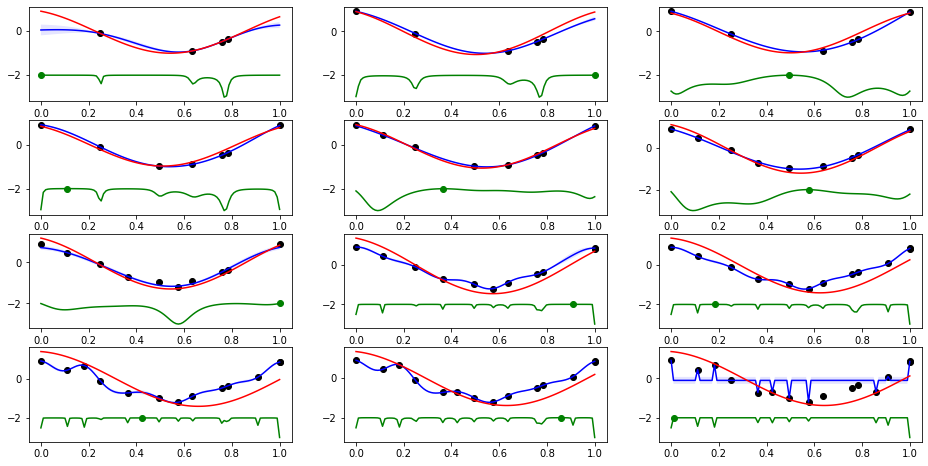

In [12]:
#ei
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16,8))
X = _X.copy()
Y = f(X)
V = np.ones_like(X)*1e-5
np.random.seed(SEED)
param = np.array([1., 5, 2.])
delta = np.random.normal(0,0.1,3*nrows*ncols).reshape((-1, 3))
for i in range(nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    m = my_lib.models.myGPHeteroscedasticRegression(X[:,None],Y[:,None])
    m['.*het_Gauss.variance'] = abs(V[:,None]) #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    with redirect_stdout(open(os.devnull, 'w')):
        m.optimize_restarts(num_restarts=100, messages=False, max_iters=10, para)
    mu, std = np.array(m.predict(X_array[:, None]))
    ax[_r, _c].plot(X_array, mu, c='b', label='mean')
    ax[_r, _c].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='b',alpha=0.1, label='Confidence')
    ax[_r, _c].scatter(X, Y, c ='black', label ='observed point')
    ax[_r, _c].plot(X_array, f(X_array, a=param[0], b=param[1], c=param[2]), c='r', label='True function')
    
    acq  = mms.fit_transform(EI.acq(mu, std))
    idx = np.argmax(acq)
    
    ax[_r, _c].plot(X_array, acq-3, c='g', label='EI')
    ax[_r, _c].scatter(X_array[idx], acq[idx]-3, c='g')
    
    X = np.append(X, X_array[idx])
    Y = np.append(Y, f(X_array[idx], a=param[0], b=param[1], c=param[2]))
    param = param + delta[i]
    v = np.sum(delta[i]**2)
    V = np.append(V + np.ones(len(V))*v, v)

In [ ]:
#ei
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16,8))
X = _X.copy()
Y = f(X)
V = np.ones_like(X)*1e-5
np.random.seed(SEED)
param = np.array([1., 5, 2.])
delta = np.random.normal(0,0.1,3*nrows*ncols).reshape((-1, 3))
for i in range(nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    m = my_lib.models.myGPHeteroscedasticRegression(X[:,None],Y[:,None])
    m['.*het_Gauss.variance'] = abs(V[:,None]) #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    with redirect_stdout(open(os.devnull, 'w')):
        m.optimize_restarts(num_restarts=100, messages=False, max_iters=10)
    mu, std = np.array(m.predict(X_array[:, None]))
    ax[_r, _c].plot(X_array, mu, c='b', label='mean')
    ax[_r, _c].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='b',alpha=0.1, label='Confidence')
    ax[_r, _c].scatter(X, Y, c ='black', label ='observed point')
    ax[_r, _c].plot(X_array, f(X_array, a=param[0], b=param[1], c=param[2]), c='r', label='True function')
    
    acq  = mms.fit_transform(UCB.acq(mu, std))
    UCB.beta *= 2
    idx = np.argmax(acq)
    
    ax[_r, _c].plot(X_array, acq-3, c='g', label='EI')
    ax[_r, _c].scatter(X_array[idx], acq[idx]-3, c='g')
    
    X = np.append(X, X_array[idx])
    Y = np.append(Y, f(X_array[idx], a=param[0], b=param[1], c=param[2]))
    param = param + delta[i]
    v = np.sum(delta[i]**2)
    V = np.append(V + np.ones(len(V))*v, v)

8/12.......